Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


input img (480, 960, 4)
 after predict (512, 1024, 3) 
 after preprocessing torch.Size([1, 3, 512, 1024])
(1.0, 2.5330429e-09)


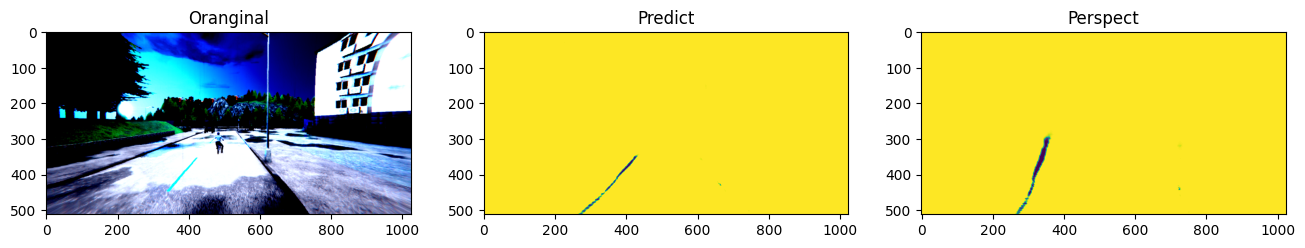

==>> fpeaks: [(323, 22), (330, 25), (336, 31), (340, 36), (347, 39), (352, 22)]


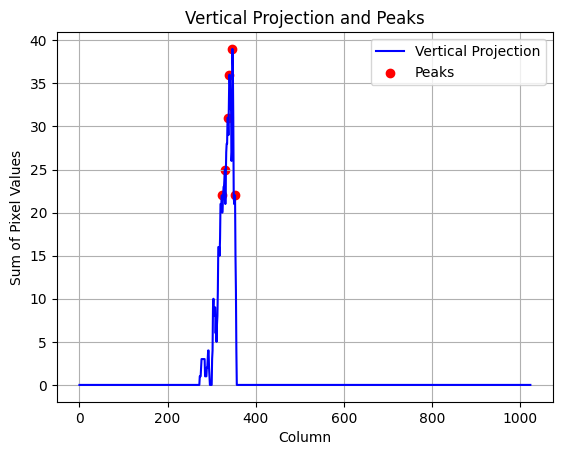

[array([-3.16525792e-04, -1.10459124e-01,  4.16341162e+02]),
 array([-3.16525792e-04, -1.10459124e-01,  4.16341162e+02]),
 array([-3.16525792e-04, -1.10459124e-01,  4.16341162e+02]),
 array([-3.16525792e-04, -1.10459124e-01,  4.16341162e+02]),
 array([-3.16525792e-04, -1.10459124e-01,  4.16341162e+02]),
 array([-3.16525792e-04, -1.10459124e-01,  4.16341162e+02]),
 array([-3.16525792e-04, -1.10459124e-01,  4.16341162e+02]),
 array([-3.16525792e-04, -1.10459124e-01,  4.16341162e+02]),
 array([-3.16525792e-04, -1.10459124e-01,  4.16341162e+02]),
 array([-3.16525792e-04, -1.10459124e-01,  4.16341162e+02]),
 array([-3.16525792e-04, -1.10459124e-01,  4.16341162e+02]),
 array([-3.16525792e-04, -1.10459124e-01,  4.16341162e+02])]


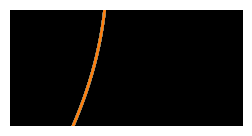

==>> fpeaks: [316, 323, 330, 336, 340, 347, 352]
==>> filtered_peaks: [352]
512.0
left right pos: (160.0, -1)
[array([ 2.82691754e-17, -7.95577668e-15,  3.51500000e+02])]


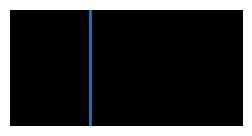

In [9]:
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
import torch
import cv2
from pprint import pprint
import natsort

from scipy.signal import find_peaks
# GET MATRIX
def get_tfuse_matrix():
    src = np.float32([
        (300, 512), (720, 512),
        (400, 350),(600, 350)
    ])
    dst = np.float32([
        (300, 512), (720, 512),
        (300, 300),(720, 300)
    ])
    Matrix = cv2.getPerspectiveTransform(src, dst)
    return Matrix

def get_train_matrix():
    src = np.float32([
        (80, 512), (1024, 500),
        (400, 250),(600, 250)
    ])
    dst = np.float32([
        (300, 512), (720, 512),
        (300, 300),(720, 300)
    ])
    Matrix = cv2.getPerspectiveTransform(src, dst)
    return Matrix

Matrix = get_train_matrix()

class LaneDetection:
    def __init__(self,model_path="./best_model_multi_dice_loss.pth") -> None:
        self.model = torch.load(model_path)
        self.preprocessing_fn = smp.encoders.get_preprocessing_fn('efficientnet-b0', 'imagenet')
        self.DEVICE  = "cuda"
    def resize_width_crop_height(self, img, target_size = (1024,512)):
        """
        Resize the image based on the width and crop the height to the target size.
        
        Parameters:
        - img: PIL Image object
        - target_size: tuple of (width, height)
        
        Returns:
        - img: PIL Image object of the target size
        """
        target_width, target_height = target_size
        
        # Calculate the new height maintaining the aspect ratio
        aspect_ratio = img.width / img.height
        new_height = int(target_width / aspect_ratio)
        
        # Resize the image based on the width
        img = img.resize((target_width, new_height), Image.ANTIALIAS)
        
        # If the new height is greater than the target height, crop the image from the center
        if new_height > target_height:
            top = (new_height - target_height) / 2
            bottom = (new_height + target_height) / 2
            img = img.crop((0, top, target_width, bottom))
        
        return img
    
    def predict(self,img,skip=False):
        if not skip:
            image = Image.fromarray(img, 'RGBA')

            #resize and corp to 512X1024
            img_resized = self.resize_width_crop_height(image)
                    # Convert RGBA to RGB
            img_resized = img_resized.convert('RGB')

            # covert to numpy array
            img_array = np.array(img_resized)
        else:
            img_array = img

        preprocessed = self.preprocessing_fn(img_array)

        # trans (width,height,channel) to (channel,width,height). change type to float32
        img_array = preprocessed.transpose(2,0,1).astype('float32')


        x_tensor = torch.from_numpy(img_array).to(self.DEVICE).unsqueeze(0)

        #predict result overall img rs[0,0,:,:], left line rs[0,0,:,:], right line rs[0,0,:,:]
        rs = self.model.predict(x_tensor)
        mask = rs[0,0,:,:].cpu().numpy().copy()
        left = rs[0,1,:,:].cpu().numpy().copy()
        right = rs[0,2,:,:].cpu().numpy().copy()
        return mask, left , right,preprocessed,rs



def get_lane_pos(arr):
    length = len(arr)
    center = 1024 / 2
    print(center)
    left = [i for i in arr if i <center]
    right = [i for i in arr if i> center]
    if len(left) == 0 :
        left = -1
    else:
        left = center - sum(left)/len(left) 
    if len(right) == 0:
        right = -1
    else:
        right = sum(right)/len(right) - center
    return left,right

def visualize(**images):
    """Plot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
def display_pl(np):
    plt.imshow(np.transpose(1,2,0))
    plt.axis('off')  # Hide axes ticks
    plt.show()
def plot_vertical_projection(vertical_projection, peaks, filename = None):
    plt.plot(vertical_projection, color='blue', label='Vertical Projection')
    plt.scatter(peaks, vertical_projection[peaks], color='red', marker='o', label='Peaks')

    plt.title('Vertical Projection and Peaks')
    plt.xlabel('Column')
    plt.ylabel('Sum of Pixel Values')
    plt.grid(True)
    plt.legend()

    if filename is not None:
        plt.savefig(filename)
    plt.show()
    plt.close()
def finding_line(warped_mask, x_points, sliding_window_num=9, margin=15, min_pixels_threshold=50):
    # 获取图像的高度和宽度
    height, width = warped_mask.shape

    # 获取图像中所有非零像素的坐标
    nonzero_y, nonzero_x = np.nonzero(warped_mask)

    # 计算滑动窗口的高度
    sliding_window_height = height // sliding_window_num

    # 用于存储每个滑动窗口内的像素索引
    line_pixel_indexes = [[] for _ in range(len(x_points))]

    # 遍历滑动窗口
    for i in range(sliding_window_num):
        for idx, x_point in enumerate(x_points):
            # 确定窗口在y轴上的边界
            top, bottom = height - (i + 1) * sliding_window_height, height - i * sliding_window_height

            # 确定窗口在x轴上的边界
            left, right = x_point - margin, x_point + margin

            # 获取窗口内的非零像素索引
            window_pixel_indexes = ((nonzero_y >= top) & (nonzero_y < bottom) &
                                    (nonzero_x >= left) & (nonzero_x < right)).nonzero()[0]

            # 存储当前窗口内的像素索引
            line_pixel_indexes[idx].append(window_pixel_indexes)

            # 如果像素数量足够，更新窗口中心位置
            if len(window_pixel_indexes) > min_pixels_threshold:
                x_point = int(np.mean(nonzero_x[window_pixel_indexes]))

    # 用于存储拟合的曲线系数
    lines = []

    # 处理每个滑动窗口的像素索引
    for line_pixel_index in line_pixel_indexes:
        # 合并像素索引
        line_pixel_index = np.concatenate(line_pixel_index)

        # 提取坐标
        line_x, line_y = nonzero_x[line_pixel_index], nonzero_y[line_pixel_index]

        # 使用多项式拟合曲线，并将结果添加到lines中
        lines.append(np.polyfit(line_y, line_x, 2))

    return lines
def plot_fitting_lines(mask, lines, filename = None):
    warp_zero = np.zeros_like(mask).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    plt.figure(figsize=(3, 5))

    for line in lines:
        y = np.linspace(0, mask.shape[0]-1, mask.shape[0])
        x = np.polyval(line, y)
        plt.plot(x, y, linewidth=2)

    plt.axis('off')
    plt.imshow(color_warp)

    if filename is not None:
        plt.savefig(filename, bbox_inches='tight', pad_inches=0, transparent=True, dpi=130)
    plt.show()
    plt.close()

def plot_filter_lines(mask, lines, filename = None):
    warp_zero = np.zeros_like(mask).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    plt.figure(figsize=(3, 5))

    for (x, y) in lines:
        plt.plot(x, y, linewidth=2)

    plt.axis('off')
    plt.imshow(color_warp)

    if filename is not None:
        plt.savefig(filename, bbox_inches='tight', pad_inches=0, transparent=True, dpi=130)
    plt.show()
    plt.close()


from pathlib import Path

Tfuse = Path("/home/ddmonster/MLMAS_Project/imgdata/tfuse")
tfuse =natsort.natsorted(list(Tfuse.glob("*.png")))
Lav = Path("/home/ddmonster/MLMAS_Project/imgdata/lav")
lav = natsort.natsorted(list(Lav.glob("*.png")))


tdir = Path("/home/ddmonster/lane_det_dataset/train")
timgs = list(tdir.glob("*.png"))


model = LaneDetection()




def convert(org,th,a,b):
    return np.where(org >= th,a,b)

def run(i,Matrix):
    # Open the image file
    img = Image.open(i)
    
    o , left, right,pr,rs = model.predict(np.array(img))
    #(256, 512, 3)  height width , channel
    af_img =np.array(rs[0].cpu().numpy().copy())
    print(f'''input img {np.shape(img)}\n after predict {np.shape(pr)} \n after preprocessing {np.shape(rs)}''')


    warped_mask = cv2.warpPerspective(o, Matrix, (1024, 512),cv2.INTER_LINEAR)
    tt = np.max(warped_mask) , np.min(warped_mask)
    print(tt)
    visualize(oranginal=pr,predict=o,perspect=warped_mask)

    # 计算垂直方向的像素值累加投影
    vertical_projection = np.sum(np.where(warped_mask >= 0.1, 0, 1), axis=0)
    # 使用find_peaks函数查找峰值点
    peaks, _ = find_peaks(vertical_projection, height=0)
    fpeaks = [index for index in peaks if vertical_projection[index] > 17]
    print(f"==>> fpeaks: {[(i,vertical_projection[i]) for i in fpeaks]}")
    plot_vertical_projection(vertical_projection, fpeaks)

    lines = finding_line(np.where(warped_mask >= 0.1, 0, 1),peaks,margin=200,min_pixels_threshold=500)
    pprint(lines)
    plot_fitting_lines(warped_mask, lines)
    # oi = Image.fromarray(o,'RGB')
    # oi.save(f"/home/ddmonster/MLMAS_Project/imgdata/predicted/{i.name}.png")

    # 一次筛选
    fpeaks = [index for index in peaks if vertical_projection[index] > 10]
    print(f"==>> fpeaks: {fpeaks}")

    # 二次筛选
    filtered_peaks = [fpeaks[0]]
    for i in range(1, len(fpeaks)):
        if fpeaks[i] - filtered_peaks[-1] < 10:
            # 如果 x 差值小于20，保留 y 值较大的点
            if fpeaks[i] > filtered_peaks[-1]:
                filtered_peaks[-1] = fpeaks[i]
        else:
            # 如果 x 差值大于等于20，直接添加到筛选后的列表
            filtered_peaks.append(fpeaks[i])

    print(f"==>> filtered_peaks: {filtered_peaks}")
    print(f"left right pos: {get_lane_pos(filtered_peaks)}")
    filter_lines = finding_line(warped_mask, filtered_peaks)
    pprint(filter_lines)
    plot_fitting_lines(warped_mask, filter_lines)

run(tfuse[0],get_tfuse_matrix())

In [ ]:
img = Image.open("/home/ddmonster/MLMAS_Project/imgdata/predicted/saved_image_rgb_front_20240701_065243.png.png")
print(np.shape(img))
plt.imshow(img)

In [ ]:
import os

def remove_files_ending_with_png_png(directory):
    # Loop through all files in the specified directory
    for filename in os.listdir(directory):
        # Check if the file ends with 'png.png'
        if filename.endswith("png.png"):
            # Construct the full file path
            file_path = os.path.join(directory, filename)
            # Remove the file
            os.remove(file_path)
            print(f"Removed file: {file_path}")

# Usage example
directory_path = '/home/ddmonster/MLMAS_Project/imgdata'
remove_files_ending_with_png_png(directory_path)